# *Transfer learning*

Transfer learning odnosi se na tehniku u kojoj se model treniran za jedan zadatak prilagođava za drugi, povezani zadatak, omogućujući ponovnu upotrebu znanja stečenog tijekom početnog treniranja. Ovaj pristup dokazao se iznimno učinkovitim u poboljšanju performansi modela, posebno kada su označeni podaci za ciljni zadatak ograničeni.

Postoje razne tehnike koje se koriste u *transfer learningu*. Često se koriste modeli već istrenirani na nekakvom velikom podatkovnom skupu, tzv. *pre-trained* modeli. Takav model je onda potrebno prilagoditi zadatku koji rješavamo. Primjerice, ako je taj model treniran za zadatak klasfikacije 1000 klasa, a naš zadatak sadrži samo 10 klasa, potrebno je prilagoditi posljednji sloj modela za naš zadatak. Također je moguće *zamrznuti* slojeve modela koje ne želimo trenirati te samo trenirati taj posljednji, novi sloj modela. Osim toga, moguće je treniranje cijelog modela odjednom, ovo se najčešće radi s malom stopom učenja i naziva se *fine-tuning*.

Osim korištenja *pre-trained* modela treniranih na velikim podatkvonim skupovima, moguće je dobiti i takav model pomoću samonadziranog (*self-supervised*) učenja. Ova tehnika predstavlja pristup strojnom učenju gdje se model trenira na pretpostavljenom zadatku, obično stvaranjem umjetnih oznaka koje se predviđaju iz samih ulaznih podataka, omogućujući modelu učenje korisnih reprezentacija koje se kasnije mogu fino prilagoditi za konkretne zadatke.

Bitni pojmovi:
 * *pre-trained* modeli
 * izdvajanje značajki (*feature extraction*)
 * zamrzavanje slojeva
 * *fine-tuning*


 ### *Transfer learning* proces:
 1. Odabir istrenirane CNN mreže
 2. Izbacivanje zadnjeg sloja i zamrzavanje mreže
 3. Dodavanje novog sloja i treniranje na novom skupu podataka
 4. Opcionalno *fine-tuneanje* cijele mreže na novom podatkovnom skupu

## Popularne arhitekture

#### VGG

[VGG](https://arxiv.org/pdf/1409.1556.pdf) konvolucijska neuronska mreža koristi niz konvolucijskih slojeva popraćenih ReLU aktivacijskom funkcijom i slojevima sažimanja. U svim slojevima konvolucije, koristi 3x3 filtere. Postoje razne verzije VGG arhitekture, neke od kojih su dostupne u [PyTorchu](https://pytorch.org/vision/stable/models/vgg.html).

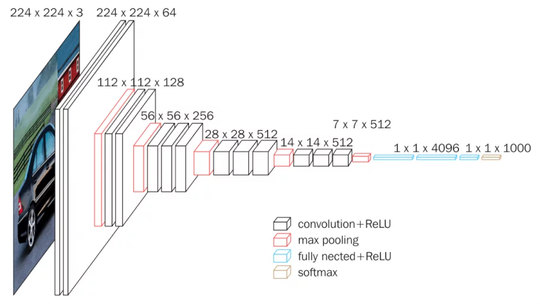

#### ResNet

[ResNet](https://arxiv.org/pdf/1512.03385.pdf) koristi niz tzv. rezidualnih blokova. Rezidualni blokovi se sastoje od dva konvolucijska sloja i *skip connections* koje jednostavno spajaju (zbrajaju) ulaz u te konvolucijske slojeve s izlazom iz istih te se tako dobiva izlaz iz rezidualnog bloka. Takav jedan blok je prikazan na shemi. U [PyTorchu](https://pytorch.org/vision/stable/models/resnet.html) također postoje razne verzije ResNet arhitekture.

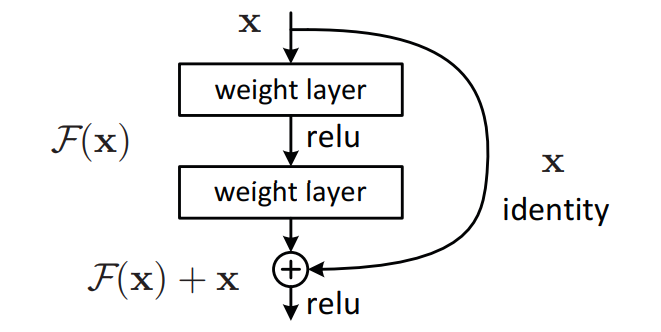

#### EfficientNet

Autori [EfficientNeta](https://arxiv.org/pdf/1905.11946.pdf) predlažu *compound scaling* metodologiju koja jednostavno i efikasno prilagođava 3 dimenzije mreže, dubinu (broj slojeva), širinu (broj filtera u svakom sloju) i rezoluciju slike. Održava se ravnoteža između tih dimenzija. Postoje razne verzije ove arhitekture B1-B7 i dostupne su u [PyTorchu](https://pytorch.org/vision/stable/models/efficientnet.html).

## Korištenje gotovih struktura CNN

Pytorch ima velik broj već definiranih [CNN struktura](https://pytorch.org/vision/stable/models.html). Za mnoge od ovih struktura su također dostupni i već istrenirani modeli na raznim podatkovnim skupovima. Za klasifikaciju su najčešće trenirani na dijelu podatkovnog skupa [ImageNet](https://www.image-net.org/) koji se sastoji od slika svrstanih u 1000 kategorija.

In [5]:
## Importing useful libraries
import os
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import torchvision
from torchvision.models import vgg16

import matplotlib.pyplot as plt
from imageio.v2 import imread
%matplotlib inline

from tqdm.notebook import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


U nastavku je prikazano kreiranje [ResNet50](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50) modela. Moguće je dohvaćanje modela s *pre-trained* težinama ili s nasumično inicijaliziranim težinama.

In [14]:
from torchvision.models import resnet50

# Pre-trained network
pt_model = resnet50(weights="IMAGENET1K_V2")

# No weights - random initialization
rnd_model = resnet50(weights=None)

In [15]:
from torchsummary import summary
# print out the layers of the network
pt_model.to(device)
summary(pt_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

Moguće je pristupiti blokovima neuronske mreže pomoću funkcije `children()`. Ova funkcija vraća generator koji se onda može predati klasi `nn.ModuleList` kako bi se dobila lista modula. Za potrebe *transfer learninga*, potrebni su nam svi moduli osim posljednjeg potpuno povezanog sloja pa je na dolje prikazani način moguće dobiti sve slojeve mreže ResNet50 osim posljednjeg. Također može biti potrebno dodati `flatten()` sloj prije dodavanja novog sloja.

In [4]:
nn.ModuleList(pt_model.children())[:-1]

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


Ako želimo dohvatiti broj značajki koje ulaze u posljednji sloj mreže, to je moguće pomoću sljedeće naredbe:

In [5]:
nn.ModuleList(pt_model.children())[-1].in_features

2048

### Zamrzavanje slojeva

Zamrzavanje slojeva se vrši na način da se slojevima koji se žele zamrznuti postavi vrijednost `requires_grad` na `False`. Dolje je prikazan način da se zamrznu svi slojevi *feature extractora* mreže ResNet50.

In [6]:
feature_extractor = nn.ModuleList(pt_model.children())[:-1]
for param in feature_extractor.parameters():
  param.requires_grad = False

# Zadaci

1. Napravite novu konvolucijsku mrežu koja će u konstruktoru primati *pre-trained* neuronsku mrežu i broj klasa. Izbacite posljednji sloj predane neuronske mreže te dodajte novi sloj ovisno o broju klasa. Zamrznite sve slojeve neuronske mreže osim novog, dodanog sloja.

2. Odaberite neku od struktura dostupnih u PyTorchu te istrenirajte vašu  modificiranu mrežu na Cifar10 podatkovnom skupu. Evaluirajte mrežu na testnom podatkovnom skupu te usporedite rezultate s onima koje ste dobili u LV2 i LV3.

3. Odmrznite sve slojeve mreže i *fine-tuneajte* ju s vrlo niskom stopom učenja na Cifar10 podatkovnom skupu. Evaluirajte i usporedite rezultate.

4. Isprobajte prethodne zadatke s različitim mrežama dostupnima u PyTorchu te usporedite rezultate.

In [9]:
class CustomResNet(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super(CustomResNet, self).__init__()

        self.features = nn.Sequential(*list(pretrained_model.children())[:-1])

        in_features = pretrained_model.fc.in_features
        self.new_layer = nn.Linear(in_features, num_classes)

        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.new_layer(x)
        return x

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

num_classes = 10

custom_model = CustomResNet(pt_model, num_classes)
custom_model.to(device)

summary(custom_model, (3, 32, 32))

Device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14      

In [16]:
num_classes = 10
learning_rate = 0.001
batch_size = 64
epochs = 10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

custom_res_net = CustomResNet(resnet50(weights="IMAGENET1K_V2"), num_classes)
custom_res_net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_res_net.parameters(), lr=learning_rate)

for epoch in range(epochs):
    custom_res_net.train()
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = custom_res_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Training Loss: {running_loss / len(train_loader)}')

custom_res_net.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Evaluating', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = custom_res_net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10:   0%|          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.7808917587065636


Epoch 2/10:   0%|          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.641897651240649


Epoch 3/10:   0%|          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.6178104906435817


Epoch 4/10:   0%|          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.6189305876831874


Epoch 5/10:   0%|          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.615097896979593


Epoch 6/10:   0%|          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.6135389856670215


Epoch 7/10:   0%|          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.6145778554479788


Epoch 8/10:   0%|          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.6102656624506198


Epoch 9/10:   0%|          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.6116668373117666


Epoch 10/10:   0%|          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.6103615501652593


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Accuracy: 46.36%


In [17]:
num_classes = 10
learning_rate_fine_tune = 0.0001
batch_size = 64
epochs_fine_tune = 5

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for param in custom_res_net.parameters():
    param.requires_grad = True

optimizer_fine_tune = optim.Adam(custom_res_net.parameters(), lr=learning_rate_fine_tune)

for epoch in range(epochs_fine_tune):
    custom_res_net.train()
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f'Fine-tuning Epoch {epoch + 1}/{epochs_fine_tune}', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_fine_tune.zero_grad()

        outputs = custom_res_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_fine_tune.step()

        running_loss += loss.item()

    print(f'Fine-tuning Loss: {running_loss / len(train_loader)}')

custom_res_net.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Evaluating (Fine-tuned)', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = custom_res_net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_fine_tune = correct / total
print(f'Test Accuracy after Fine-tuning: {accuracy_fine_tune * 100:.2f}%')

Files already downloaded and verified
Files already downloaded and verified


Fine-tuning Epoch 1/5:   0%|          | 0/782 [00:00<?, ?it/s]

Fine-tuning Loss: 1.0584430264313813


Fine-tuning Epoch 2/5:   0%|          | 0/782 [00:00<?, ?it/s]

Fine-tuning Loss: 0.5482622120920044


Fine-tuning Epoch 3/5:   0%|          | 0/782 [00:00<?, ?it/s]

Fine-tuning Loss: 0.3280717623241417


Fine-tuning Epoch 4/5:   0%|          | 0/782 [00:00<?, ?it/s]

Fine-tuning Loss: 0.21363609641923775


Fine-tuning Epoch 5/5:   0%|          | 0/782 [00:00<?, ?it/s]

Fine-tuning Loss: 0.14970414509610905


Evaluating (Fine-tuned):   0%|          | 0/157 [00:00<?, ?it/s]

Test Accuracy after Fine-tuning: 82.76%


In [7]:
num_classes = 10
learning_rate = 0.001
batch_size = 64
epochs = 10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

pretrained_model_vgg16 = vgg16(pretrained=True)

class CustomVGG16Net(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super(CustomVGG16Net, self).__init__()

        self.features = nn.Sequential(*list(pretrained_model.features.children()))

        self.new_layer = nn.Linear(512, num_classes)

        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.new_layer(x)
        return x

custom_vgg16_net = CustomVGG16Net(pretrained_model_vgg16, num_classes)
custom_vgg16_net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_vgg16_net.parameters(), lr=learning_rate)

for epoch in range(epochs):
    custom_vgg16_net.train()
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = custom_vgg16_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Training Loss: {running_loss / len(train_loader)}')

custom_vgg16_net.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Evaluating', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = custom_vgg16_net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_vgg16 = correct / total
print(f'Test Accuracy (VGG16): {accuracy_vgg16 * 100:.2f}%')

Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10:   0%|          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1574244214903058


Epoch 2/10:   0%|          | 0/782 [00:00<?, ?it/s]

Training Loss: 0.9862364610595167


Epoch 3/10:   0%|          | 0/782 [00:00<?, ?it/s]

Training Loss: 0.9542229903476013


Epoch 4/10:   0%|          | 0/782 [00:00<?, ?it/s]

Training Loss: 0.939495852078928


Epoch 5/10:   0%|          | 0/782 [00:00<?, ?it/s]

Training Loss: 0.9309275099993362


Epoch 6/10:   0%|          | 0/782 [00:00<?, ?it/s]

Training Loss: 0.9261905711782558


Epoch 7/10:   0%|          | 0/782 [00:00<?, ?it/s]

Training Loss: 0.9221810309783273


Epoch 8/10:   0%|          | 0/782 [00:00<?, ?it/s]

Training Loss: 0.9202284546916747


Epoch 9/10:   0%|          | 0/782 [00:00<?, ?it/s]

Training Loss: 0.9187232230020606


Epoch 10/10:   0%|          | 0/782 [00:00<?, ?it/s]

Training Loss: 0.9163387489821905


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Accuracy (VGG16): 65.32%
